In [33]:
from Eof_functions import *

path = 'C:\\Users\\ratynski\\Documents\\Python_Projects\\stratocu_waves-main\\DATA\\2022_09_06\\'
os.chdir(path)
files = glob.glob('*.png')

#for each image, create a frame_letter variable that will be used to store the imread image

frame_a = tools.imread(path + files[0])
frame_b = tools.imread(path + files[1])
frame_c = tools.imread(path + files[2])
frame_d = tools.imread(path + files[3])
frame_e = tools.imread(path + files[4])
frame_f = tools.imread(path + files[5])
frame_g = tools.imread(path + files[6])
frame_h = tools.imread(path + files[7])
frame_i = tools.imread(path + files[8])
frame_j = tools.imread(path + files[9])

frames = np.array([frame_a, frame_b, frame_c, frame_d, frame_e, frame_f, frame_g, frame_h, frame_i, frame_j])

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from scipy.fft import fftn, fftshift
from scipy.optimize import curve_fit

def bisinusoidal_func(theta, A1, phi1, C):
    return A1 * np.cos(2 * theta + phi1) +  C

def bi_sinezoidal_fitting(theta, data):
    # Initial guess for the parameters: A1, phi1, A2, phi2, C
    initial_guess = [1, 0, 1]
    params, _ = curve_fit(bisinusoidal_func, theta, data, p0=initial_guess)
    return params


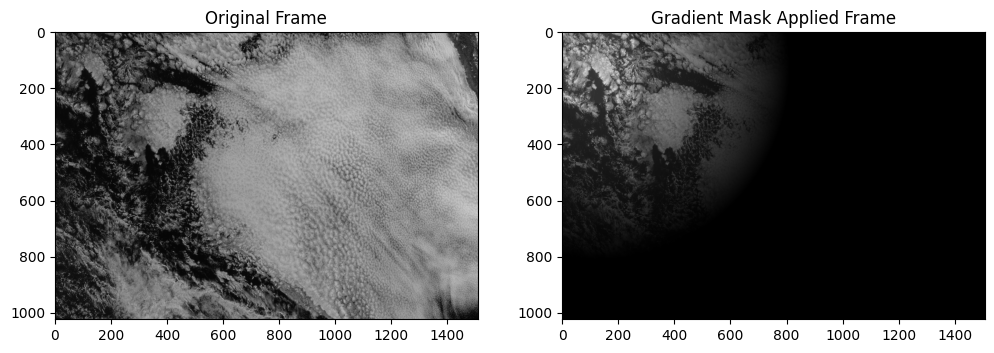

In [35]:
frame=frames[0,:,:]

data_shape = frame.shape
all_directions = []
all_amplitudes = []

data_shape = frame.shape
square_size = 128 * 2
overlap = 0.5
step_size = int(square_size * (1 - overlap))
strength = 0.75  # Adjust this value to control the gradient strength 0.1 -> Abrupt, 1 -> Slow

kl_cutoff_inf = 0.01
kl_cutoff_sup = 0.1
wavenumber_step = 0.01
wavenumber_values = np.arange(kl_cutoff_inf, kl_cutoff_sup, wavenumber_step)

i, j = 1, 1

# Create a mask for the entire frame
mask = np.zeros(data_shape)

# Create a 2D radial gradient mask for the area outside the square
y, x = np.ogrid[:data_shape[0], :data_shape[1]]
center_y, center_x = i + square_size // 2, j + square_size // 2
distance_from_center = np.sqrt((x - center_x)**2 + (y - center_y)**2)
max_distance = strength * np.sqrt((data_shape[0] / 2)**2 + (data_shape[1] / 2)**2)
gradient_mask = 1 - np.clip(distance_from_center / max_distance, 0, 1)

# Apply the gradient mask to the area outside the central square
mask[i:i+square_size, j:j+square_size] = 1
mask = np.maximum(mask, gradient_mask)

# Apply the mask to the frame
blurred_frame = frame * mask

# Visualization
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].imshow(frame, cmap='gray')
axs[0].set_title("Original Frame")
axs[1].imshow(blurred_frame, cmap='gray')
axs[1].set_title("Gradient Mask Applied Frame")
plt.show()

In [36]:
# Set the plot condition
Plot = False

fft_data = fftn(frame)  # Use the entire frame, not the smoothed version
fft_data = fftshift(fft_data)

# Calculate kl unitlessly for each pixel
k = fftshift(np.fft.fftfreq(data_shape[1], d=1/data_shape[1]))
l = fftshift(np.fft.fftfreq(data_shape[0], d=1/data_shape[0]))
k, l = np.meshgrid(k, l)

k = k / data_shape[1]
l = l / data_shape[0]

radius = np.sqrt(k**2 + l**2)
theta = np.arctan2(l, k)
amplitude = np.abs(fft_data)

directions = []
amplitudes = []

# Define wavenumber range
kl_cutoff_inf = 0.01
kl_cutoff_sup = 0.1
wavenumber_step = 0.01
wavenumber_values = np.arange(kl_cutoff_inf, kl_cutoff_sup, wavenumber_step)

for wavenumber in wavenumber_values:
    mask = (radius > (wavenumber - wavenumber_step/2)) & (radius < (wavenumber + wavenumber_step/2))
    if np.any(mask):
        extracted_data = amplitude[mask]
        theta_flat = theta[mask]
        
        # Create theta bins
        num_bins = 36  # 10 degrees each bin
        theta_bins = np.linspace(np.min(theta_flat), np.max(theta_flat), num_bins + 1)
        mean_amplitude = np.zeros(num_bins)

        for j in range(num_bins):
            in_bin = (theta_flat >= theta_bins[j]) & (theta_flat < theta_bins[j + 1])
            mean_amplitude[j] = np.mean(extracted_data[in_bin])

        # Perform bisinusoidal fitting
        initial_guess = [np.max(mean_amplitude), 0, np.mean(mean_amplitude)]
        popt, _ = curve_fit(bisinusoidal_func, theta_bins[:-1], mean_amplitude, p0=initial_guess)

        # Calculate direction and amplitude based on the fit
        theta_fit = theta_bins[:-1]
        fitted_amplitude = bisinusoidal_func(theta_fit, *popt)
        max_indices = np.argsort(fitted_amplitude)[-2:]  # Indices of the two largest values

        direction_1 = theta_fit[max_indices[0]] * 180 / np.pi   # X value for the first maximum Y in degrees
        amplitude_1 = np.max([fitted_amplitude[max_indices[0]],fitted_amplitude[max_indices[1]]])  # First maximum Y value

        direction_2 = theta_fit[max_indices[1]] * 180 / np.pi   # X value for the second maximum Y in degrees


        # Plot the amplitude vs. angle and the fit if Plot is True
        if Plot:
            plt.figure(figsize=(10, 6))
            plt.plot(theta_bins[:-1] * 180 / np.pi, mean_amplitude, label='Mean Amplitude')
            plt.plot(theta_bins[:-1] * 180 / np.pi, bisinusoidal_func(theta_bins[:-1], *popt), 'r-', label='Bisinusoidal Fit')
            plt.title(f'Amplitude vs. Angle for Wavenumber {wavenumber}')
            plt.xlabel('Angle (degrees)')
            plt.ylabel('Amplitude')
            plt.legend()
            plt.grid(True)
            plt.show()
            print(f'Fitted parameters for wavenumber {wavenumber}: A1 = {popt[0]}, phi1 = {popt[1]}, C = {popt[2]}')

        # Print the calculated directions and amplitudes
        print(f'Calculated directions: {direction_1} degrees, {direction_2} degrees')
        print(f'Calculated amplitude: {amplitude_1}')

        # Store direction and amplitude data
        directions.append((direction_1, direction_2))
        amplitudes.append((amplitude_1))

all_directions = directions
all_amplitudes = amplitudes


Calculated directions: -47.553308220651004 degrees, 130.53188951724977 degrees
Calculated amplitude: 704630.6492252809
Calculated directions: -48.54380862311183 degrees, 130.3165633428018 degrees
Calculated amplitude: 298263.74010193633
Calculated directions: -48.963593943917864 degrees, 130.22530566436572 degrees
Calculated amplitude: 191828.0938701672
Calculated directions: -49.19553968256732 degrees, 130.1748826777028 degrees
Calculated amplitude: 145900.25811918548
Calculated directions: 130.14289959024455 degrees, -49.3426618848753 degrees
Calculated amplitude: 119603.9483096819
Calculated directions: 130.11957289894295 degrees, -49.44996466486243 degrees
Calculated amplitude: 102777.30633788201
Calculated directions: -39.54370977141773 degrees, 140.08296185974223 degrees
Calculated amplitude: 85969.97181053755
Calculated directions: 140.07324068156078 degrees, -39.59717625141571 degrees
Calculated amplitude: 73027.5731112141
Calculated directions: 140.06555866754024 degrees, -39.

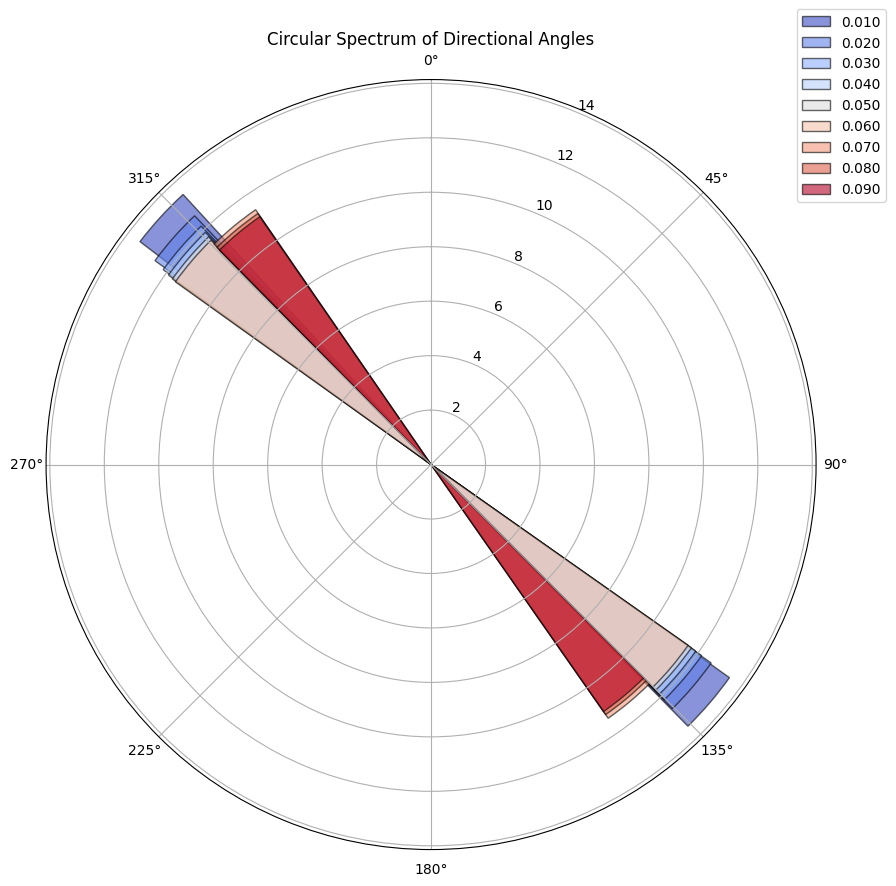

In [37]:
def visualize_results(all_directions, all_amplitudes, wavenumber_values, log=True):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, polar=True)
    cmap = plt.get_cmap('coolwarm')
    colors = cmap(np.linspace(0, 1, len(wavenumber_values)))

    for i, wavenumber in enumerate(wavenumber_values):
        if i < len(all_directions) and i < len(all_amplitudes):
            directions = all_directions[i]
            amplitude = all_amplitudes[i]

            if log:
                # Apply log scale to amplitudes
                amplitude = np.log(amplitude + 1)  # Adding 1 to avoid log(0)

            # Wrap angles to the range [0, 360] degrees
            directions_wrapped = np.mod(directions, 360)

            # Plot the histogram for both directions with the same amplitude
            for direction in directions_wrapped:
                ax.bar(np.deg2rad(direction), amplitude, width=np.deg2rad(10), color=colors[i], alpha=0.6, edgecolor='k', label=f'{wavenumber:.3f}' if direction == directions_wrapped[0] else "")

    ax.set_title('Circular Spectrum of Directional Angles')
    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)
    plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
    plt.show()

# Example usage:
visualize_results(all_directions, all_amplitudes, wavenumber_values, log=True)

In [ ]:
# Now here's a different method where we use a continuous function over the full range of angles 
# We then plot this function in polar coordinates with the amplitude as the radius and the direction as the angle.

directions = []
amplitudes = []

for wavenumber in wavenumber_values:
    mask = (radius > (wavenumber - wavenumber_step / 2)) & (radius < (wavenumber + wavenumber_step / 2))
    if np.any(mask):
        extracted_data = amplitude[mask]
        theta_flat = theta[mask]
        
        # Perform bi-sinusoidal fitting
        params = bi_sinezoidal_fitting(theta_flat, extracted_data)
        
        # Generate continuous direction data
        theta_cont = np.linspace(-np.pi, np.pi, 360)
        fitted_amplitudes = bisinusoidal_func(theta_cont, *params)
        
        # Store direction and amplitude data
        directions.append(theta_cont)
        amplitudes.append(fitted_amplitudes)

all_directions = directions
all_amplitudes = amplitudes

# Visualize the results
def visualize_results_continuous(all_directions, all_amplitudes, wavenumber_values, log=True):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, polar=True)
    cmap = plt.get_cmap('coolwarm')
    colors = cmap(np.linspace(0, 1, len(wavenumber_values)))
    
    plotted_wavenumbers = set()
    for i, wavenumber in enumerate(wavenumber_values):
        if i < len(all_directions) and i < len(all_amplitudes):
            theta_cont = all_directions[i]
            fitted_amplitudes = all_amplitudes[i]
            
            if log:
                # Apply log scale to amplitudes
                fitted_amplitudes = np.log(fitted_amplitudes + 1)  # Adding 1 to avoid log(0)
            
            # Wrap angles to the range [0, 2*pi]
            theta_wrapped = np.mod(theta_cont, 2 * np.pi)
            
            # Plot the fitted function
            if wavenumber not in plotted_wavenumbers:
                ax.plot(theta_wrapped, fitted_amplitudes, color=colors[i], alpha=0.6, label=f'{wavenumber:.3f}')
                plotted_wavenumbers.add(wavenumber)
            else:
                ax.plot(theta_wrapped, fitted_amplitudes, color=colors[i], alpha=0.6)
    
    ax.set_title('Circular Spectrum of Directional Angles')
    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)
    plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
    plt.show()

visualize_results_continuous(all_directions, all_amplitudes, wavenumber_values, log=False)

One big function that returns the frame and the corresponding rose plot

In [38]:
def bisinusoidal_func(theta, A1, phi1, C):
    return A1 * np.cos(2 * theta + phi1) +  C

def analyze_frame(frame, square_size=256, overlap=0.5, strength=0.75, kl_cutoff_inf=0.01, 
                  kl_cutoff_sup=0.1, wavenumber_step=0.01, log=True, plot_condition=False):
    
    data_shape = frame.shape
    all_directions = []
    all_amplitudes = []

    step_size = int(square_size * (1 - overlap))
    wavenumber_values = np.arange(kl_cutoff_inf, kl_cutoff_sup, wavenumber_step)

    for i in range(0, data_shape[0] - square_size + 1, step_size):
        for j in range(0, data_shape[1] - square_size + 1, step_size):
            # Create a mask for the entire frame
            mask = np.zeros(data_shape)

            # Create a 2D radial gradient mask for the area outside the square
            y, x = np.ogrid[:data_shape[0], :data_shape[1]]
            center_y, center_x = i + square_size // 2, j + square_size // 2
            distance_from_center = np.sqrt((x - center_x)**2 + (y - center_y)**2)
            max_distance = strength * np.sqrt((data_shape[0] / 2)**2 + (data_shape[1] / 2)**2)
            gradient_mask = 1 - np.clip(distance_from_center / max_distance, 0, 1)

            # Apply the gradient mask to the area outside the central square
            mask[i:i+square_size, j:j+square_size] = 1
            mask = np.maximum(mask, gradient_mask)

            # Apply the mask to the frame
            blurred_frame = frame * mask

            # Perform FFT on the entire frame
            fft_data = fftn(blurred_frame)
            fft_data = fftshift(fft_data)

            # Calculate kl unitlessly for each pixel
            k = fftshift(np.fft.fftfreq(data_shape[1], d=1/data_shape[1]))
            l = fftshift(np.fft.fftfreq(data_shape[0], d=1/data_shape[0]))
            k, l = np.meshgrid(k, l)

            k = k / data_shape[1]
            l = l / data_shape[0]

            radius = np.sqrt(k**2 + l**2)
            theta = np.arctan2(l, k)
            amplitude = np.abs(fft_data)

            directions = []
            amplitudes = []

            for wavenumber in wavenumber_values:
                mask = (radius > (wavenumber - wavenumber_step/2)) & (radius < (wavenumber + wavenumber_step/2))
                if np.any(mask):
                    extracted_data = amplitude[mask]
                    theta_flat = theta[mask]
                    
                    # Create theta bins
                    num_bins = 36  # 10 degrees each bin
                    theta_bins = np.linspace(np.min(theta_flat), np.max(theta_flat), num_bins + 1)
                    mean_amplitude = np.zeros(num_bins)

                    for k in range(num_bins):
                        in_bin = (theta_flat >= theta_bins[k]) & (theta_flat < (theta_bins[k + 1] if k < num_bins - 1 else theta_bins[k]))
                        bin_data = extracted_data[in_bin]
                        if len(bin_data) > 0:
                            mean_amplitude[k] = np.mean(bin_data)
                        else:
                            mean_amplitude[k] = 0  # or another default value

                    # Perform bisinusoidal fitting
                    initial_guess = [np.max(mean_amplitude), 0, np.mean(mean_amplitude)]
                    popt, _ = curve_fit(bisinusoidal_func, theta_bins[:-1], mean_amplitude, p0=initial_guess)

                    # Calculate direction and amplitude based on the fit
                    theta_fit = theta_bins[:-1]
                    fitted_amplitude = bisinusoidal_func(theta_fit, *popt)
                    max_indices = np.argsort(fitted_amplitude)[-2:]  # Indices of the two largest values

                    direction_1 = theta_fit[max_indices[0]] * 180 / np.pi   # X value for the first maximum Y in degrees
                    amplitude_1 = np.max([fitted_amplitude[max_indices[0]],fitted_amplitude[max_indices[1]]])  # First maximum Y value

                    direction_2 = theta_fit[max_indices[1]] * 180 / np.pi   # X value for the second maximum Y in degrees

                    # Plot the amplitude vs. angle and the fit if Plot is True
                    if plot_condition:
                        plt.figure(figsize=(10, 6))
                        plt.plot(theta_bins[:-1] * 180 / np.pi, mean_amplitude, label='Mean Amplitude')
                        plt.plot(theta_bins[:-1] * 180 / np.pi, bisinusoidal_func(theta_bins[:-1], *popt), 'r-', label='Bisinusoidal Fit')
                        plt.title(f'Amplitude vs. Angle for Wavenumber {wavenumber}')
                        plt.xlabel('Angle (degrees)')
                        plt.ylabel('Amplitude')
                        plt.legend()
                        plt.grid(True)
                        plt.show()
                        print(f'Fitted parameters for wavenumber {wavenumber}: A1 = {popt[0]}, phi1 = {popt[1]}, C = {popt[2]}')

                    # Print the calculated directions and amplitudes
                    # print(f'Calculated directions: {direction_1} degrees, {direction_2} degrees')
                    # print(f'Calculated amplitude: {amplitude_1}')

                    # Store direction and amplitude data
                    directions.append((direction_1, direction_2))
                    amplitudes.append(amplitude_1)

            all_directions.append(directions)
            all_amplitudes.append(amplitudes)

    return all_directions, all_amplitudes, wavenumber_values

# Example usage:
frame = frame=frames[0,:,:]
all_directions, all_amplitudes, wavenumber_values = analyze_frame(frame)
# visualize_results(all_directions, all_amplitudes, wavenumber_values, log=True)


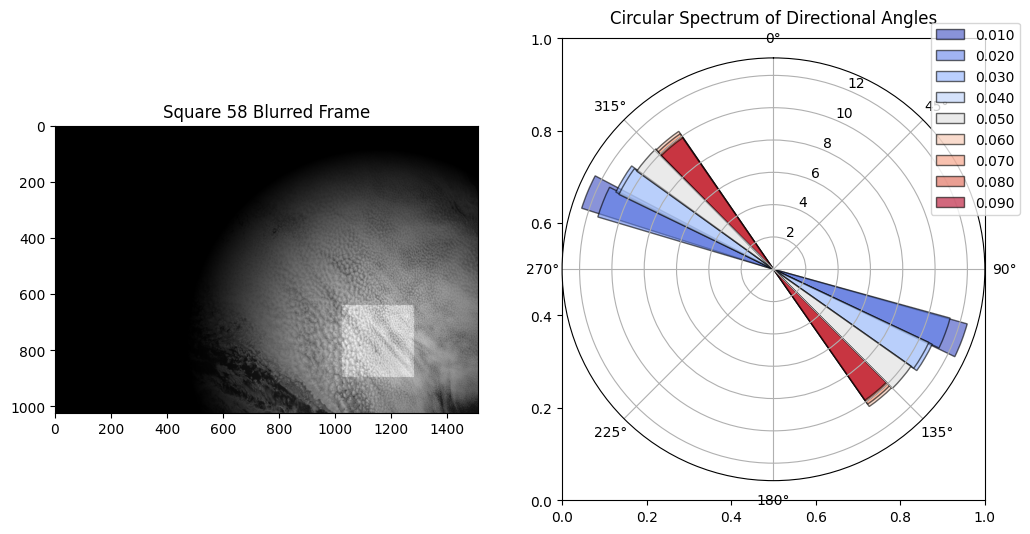

In [59]:
def visualize_results(frame, all_directions, all_amplitudes, wavenumber_values, square_number, square_size, overlap, strength=0.75, log=True):
    data_shape = frame.shape
    step_size = int(square_size * (1 - overlap))
    num_squares_per_row = (data_shape[1] - square_size) // step_size + 1
    
    i = (square_number // num_squares_per_row) * step_size
    j = (square_number % num_squares_per_row) * step_size

    # Create a mask for the entire frame
    mask = np.zeros(data_shape)

    # Create a 2D radial gradient mask for the area outside the square
    y, x = np.ogrid[:data_shape[0], :data_shape[1]]
    center_y, center_x = i + square_size // 2, j + square_size // 2
    distance_from_center = np.sqrt((x - center_x)**2 + (y - center_y)**2)
    max_distance = strength * np.sqrt((data_shape[0] / 2)**2 + (data_shape[1] / 2)**2)
    gradient_mask = 1 - np.clip(distance_from_center / max_distance, 0, 1)

    # Apply the gradient mask to the area outside the central square
    mask[i:i+square_size, j:j+square_size] = 1
    mask = np.maximum(mask, gradient_mask)

    # Apply the mask to the frame
    blurred_frame = frame * mask

    # Plot the blurred frame and the corresponding rose plot
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    ax_blur = axs[0]
    ax_polar = fig.add_subplot(122, polar=True)  # Ensure the second subplot is a polar plot
    cmap = plt.get_cmap('coolwarm')
    colors = cmap(np.linspace(0, 1, len(wavenumber_values)))

    directions = all_directions[square_number]
    amplitudes = all_amplitudes[square_number]

    for i, wavenumber in enumerate(wavenumber_values):
        if i < len(directions) and i < len(amplitudes):
            direction = directions[i]
            amplitude = amplitudes[i]

            if log:
                # Apply log scale to amplitudes
                amplitude = np.log(amplitude + 1)  # Adding 1 to avoid log(0)

            # Wrap angles to the range [0, 360] degrees
            direction_wrapped = np.mod(direction, 360)

            # Plot the histogram for both directions with the same amplitude
            for d in direction_wrapped:
                ax_polar.bar(np.deg2rad(d), amplitude, width=np.deg2rad(10), color=colors[i], alpha=0.6, edgecolor='k', label=f'{wavenumber:.3f}' if d == direction_wrapped[0] else "")

    ax_polar.set_title('Circular Spectrum of Directional Angles')
    ax_polar.set_theta_zero_location('N')
    ax_polar.set_theta_direction(-1)
    ax_polar.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))

    ax_blur.imshow(blurred_frame, cmap='gray')
    ax_blur.set_title(f'Square {square_number} Blurred Frame')

    plt.show()

# Example usage
frame = frames[0,:,:]  # Replace with actual frame data
square_size = 128 * 2
overlap = 0.5

# Define other parameters used in the function
square_number = 58  # Specify the square number you want to visualize
visualize_results(frame, all_directions, all_amplitudes, wavenumber_values, square_number, square_size, overlap, strength=0.75, log=True)